# Data Import

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#statistical analysis
from scipy import stats

#database
from sqlalchemy import create_engine

#linear models and scoring
import statsmodels.api as sm
from sklearn import linear_model #OLS model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

#optimization and metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

#display module
from IPython.display import display_html

#stats and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#formatting
# pd.options.display.float_format = '{:.3f}'.format
plt.style.use('dark_background')
pd.options.display.float_format = '{:20,.2f}'.format

#Load the houseprices data from Thinkful's database.
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



#Helpers

In [ ]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)

#Data Inspection

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 <a list of 37 Text major ticklabel objects>)

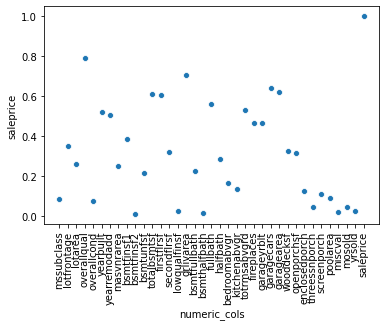

In [ ]:
corr = np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"])

corr = corr.reset_index()

corr_plot = pd.DataFrame(corr)
pd.options.display.float_format = '{:20,.2f}'.format
corr_plot.saleprice.astype(float)

# corr_plot.head()
corr_plot = corr_plot.rename(columns={'index': 'numeric_cols'})

sns.scatterplot(x='numeric_cols', y='saleprice', data=corr_plot)
plt.xticks(rotation=90)
#add y axis line for threshold prediction of best correlated features

# sns.heatmap(corr_plot) 
# ttype error could be a bug
# see https://github.com/numpy/numpy/issues/12351

In [ ]:
display(house_prices_df.head())
house_prices_df.shape

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


(1460, 81)

# Data Exploration and Preprocessing

In [ ]:
house_prices_df.info()



**Observations:**  
- An ID column-repurpose as index: Spatiality provides stronger logical hierarchy.


In [ ]:
house_prices_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


We have numerical and non-numericalcolumns.   We need to define both categories of data and convert non-numeric types.  

In [ ]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns

print(non_numeric_columns)
print('The number of non-numerical columns is {}'.format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [ ]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns

print(numeric_columns)
print('The number of numerical columns is {}'.format(len(numeric_columns)))



Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


## Check for missing values

In [ ]:
house_prices_df.head()
house_prices_df.rename(columns={'	masvnrarea': 'masvnarea'}, inplace=True) #replace col name, remove space

missing_vals_cols = ['lotfrontage', 'alley', 'masvnrtype', 'masvnrarea', 'bsmtqual', 'bsmtcond', 
                     'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'fireplacequ', 'garagetype', 
                     'garageyrblt', 'garagefinish', 'garagequal', 'garagecond', 
                     'electrical', 'poolqc', 'fence', 'miscfeature']

cols_with_missing = house_prices_df[['lotfrontage', 'alley', 'masvnrtype', 'masvnrarea', 'bsmtqual', 'bsmtcond', 
                     'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'fireplacequ', 'garagetype', 
                     'garageyrblt', 'garagefinish', 'garagequal', 'garagecond', 'electrical', 
                     'poolqc', 'fence', 'miscfeature']]


Here, I referenced the information contained by calling .info() on the dataframe. For clarity, the columns with missing values are called to a list. 

In [ ]:
house_prices_df = house_prices_df.reset_index(drop=True)
# house_prices_df[['lotfrontage', 'garageyrblt', 'masvnrarea']]

In [ ]:
pd.set_option('use_inf_as_na', True) #to ensure everything comes up for missing vals check

percent_missing = (cols_with_missing.isna().sum()/(len(cols_with_missing)/ 100) * (.0100))
#define new df with missing vals
missing_vals_percent = pd.DataFrame(data=percent_missing, columns=['percentage missing'])
#sort vals highest to lowest
missing_vals_percent.sort_values(by='percentage missing', ascending=False)

,percentage missing
poolqc,0.995205
miscfeature,0.963014
alley,0.937671
fence,0.807534
fireplacequ,0.472603
lotfrontage,0.177397
garagetype,0.055479
garageyrblt,0.055479
garagefinish,0.055479
garagequal,0.055479


### Above we see that in addition to missing values as NAN, we have values inputted as 'None'.

In [ ]:
# remove = ['None', '0']

# we will need to update our dfs from above

cols_with_missing = cols_with_missing.replace(to_replace=['None'], value=np.nan, regex=True)
cols_with_missing = cols_with_missing.replace(to_replace=['0'], value=np.nan, regex=True)

percent_missing = (cols_with_missing.isna().sum()/(len(cols_with_missing)/ 100) * (.0100))
missing_vals_percent = pd.DataFrame(data=percent_missing, columns=['percentage missing'])

# cols_with_missing.info()

# missing_vals_percent.sort_values(by='percentage missing', ascending=False)

## Provide explaination for missing values

It possible the upper half of the distribution of the missing values accounts for the perimeter of the house. They could be missing due to user error or the lack of pools from the sample.

We proceed by selecting a imputation type.  Below we visualize the percent missing.

- columns with high missing values (>50%):
    - impute with mean
- for categorical columns:
    - convert to dummy variables
- for numerical columns:
    - apply log transform
    - impute with mean 

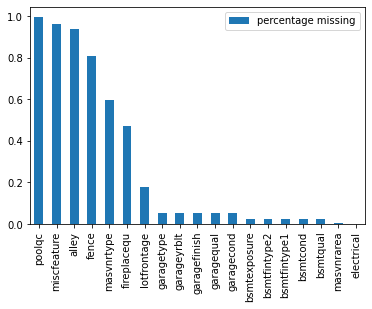

In [ ]:
missing_vals_percent.sort_values(by='percentage missing', ascending=False).plot(kind='bar')


In [ ]:
#define df with featurees missing more than 50%
high_missing_values1 = house_prices_df[['lotfrontage']] #numeric
high_missing_values2 = house_prices_df[['alley',  'poolqc', 'fence', 'miscfeature']]


#impute mean for lotfrontage
high_missing_values1.apply(lambda x: x.fillna(x.mean()))

#replace filled values into df
house_prices_df['lotfrontage'] = high_missing_values1.lotfrontage

# dummy cat cols
alley_dummy = high_missing_values2['alley'].str.get_dummies().add_prefix("alley")
poolqc_dummy = high_missing_values2['poolqc'].str.get_dummies().add_prefix("poolqc")
fence_dummy = high_missing_values2['fence'].str.get_dummies().add_prefix("fence")
miscfeature_dummy = high_missing_values2['miscfeature'].str.get_dummies().add_prefix("miscfeature")


#combine dummied cols into df
dummies = pd.concat([alley_dummy, poolqc_dummy, fence_dummy, miscfeature_dummy], axis=1)

#add suffix before merge
dummies = dummies.add_suffix("_dumm")

# merge dummies into df
house_prices_df = pd.concat([house_prices_df, dummies], axis=1)

#remove whitespace
for col in house_prices_df.columns:
    house_prices_df[col].replace(' ', '')


#make copy, drop cat cols 
hp_df = house_prices_df.copy()

hp_df = hp_df.drop(columns=['id', 'lotfrontage', 'alley', 'poolqc', 'fence',
       'miscfeature'])


#preview df 
hp_df.head()   

,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,...,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,alleyGrvl_dumm,alleyPave_dumm,poolqcEx_dumm,poolqcFa_dumm,poolqcGd_dumm,fenceGdPrv_dumm,fenceGdWo_dumm,fenceMnPrv_dumm,fenceMnWw_dumm,miscfeatureGar2_dumm,miscfeatureOthr_dumm,miscfeatureShed_dumm,miscfeatureTenC_dumm
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,...,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,...,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,...,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,0,0,0,0,0,0,0,0,0,0,0,0,0
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,...,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,0,0,0,0,0,0,0,0,0,0,0,0,0
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,...,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#update missing vals df
cols_with_missing = house_prices_df[['masvnrtype', 'masvnrarea', 'bsmtqual', 'bsmtcond', 
                     'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'fireplacequ', 'garagetype', 
                     'garageyrblt', 'garagefinish', 'garagequal', 'garagecond', 'electrical']]

#define categorcal columns 
cols_with_missing_cat = cols_with_missing.select_dtypes(['object'])

#dummy remain catergorical cols
for col in cols_with_missing_cat.columns:
    cols_with_missing_cat[col] = cols_with_missing_cat[col].str.get_dummies().add_suffix("_dumm")
    
#define df with numerical cols
# cols_with_missing_num = cols_with_missing.select_dtypes(['int64', 'float64'])
# #visualize remaining numerical cols
# cols_with_missing_num.plot(kind='box')

#address outliers
#log transform values then impute with mean
areatrans = np.log(house_prices_df['masvnrarea'])
areatrans = areatrans.fillna(value=5.227800823979176)
garagetrans = np.log(house_prices_df['garageyrblt'])
garagetrans = garagetrans.fillna(value=7.590019134707199)

#update df with transformed values
house_prices_df['masvnrarea'] = areatrans
house_prices_df['garageyrblt'] = garagetrans

#make copy, drop transformed and cat cols w/>50% missing 
hp_df = house_prices_df.copy()

hp_df = hp_df.drop(columns=['masvnrtype', 'masvnrarea', 'bsmtqual', 'bsmtcond', 
                     'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'fireplacequ', 'garagetype', 
                     'garageyrblt', 'garagefinish', 'garagequal', 'garagecond', 'electrical'])

#fixing a bug
#replace filled values into df
hp_df['lotfrontage'] = hp_df['lotfrontage'].fillna(value=70.049958)


In [ ]:
#address outliers
#log transform values then impute with mean
areatrans = np.log(house_prices_df['masvnrarea'])
areatrans = areatrans.fillna(value=5.227800823979176)
garagetrans = np.log(house_prices_df['garageyrblt'])
garagetrans = garagetrans.fillna(value=7.590019134707199)

#update df with transformed values
house_prices_df['masvnrarea'] = areatrans
house_prices_df['garageyrblt'] = garagetrans

#make copy, drop transformed and cat cols w/>50% missing 
hp_df = house_prices_df.copy()

hp_df = hp_df.drop(columns=['masvnrtype', 'masvnrarea', 'bsmtqual', 'bsmtcond', 
                     'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'fireplacequ', 'garagetype', 
                     'garageyrblt', 'garagefinish', 'garagequal', 'garagecond', 'electrical'])

#fixing a bug
#replace filled values into df
hp_df['lotfrontage'] = hp_df['lotfrontage'].fillna(value=70.049958)

### Distribution of Target Variable

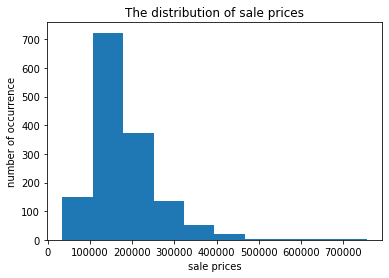

In [ ]:
plt.hist(house_prices_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

### Distribution of independent variables and normality for outliers

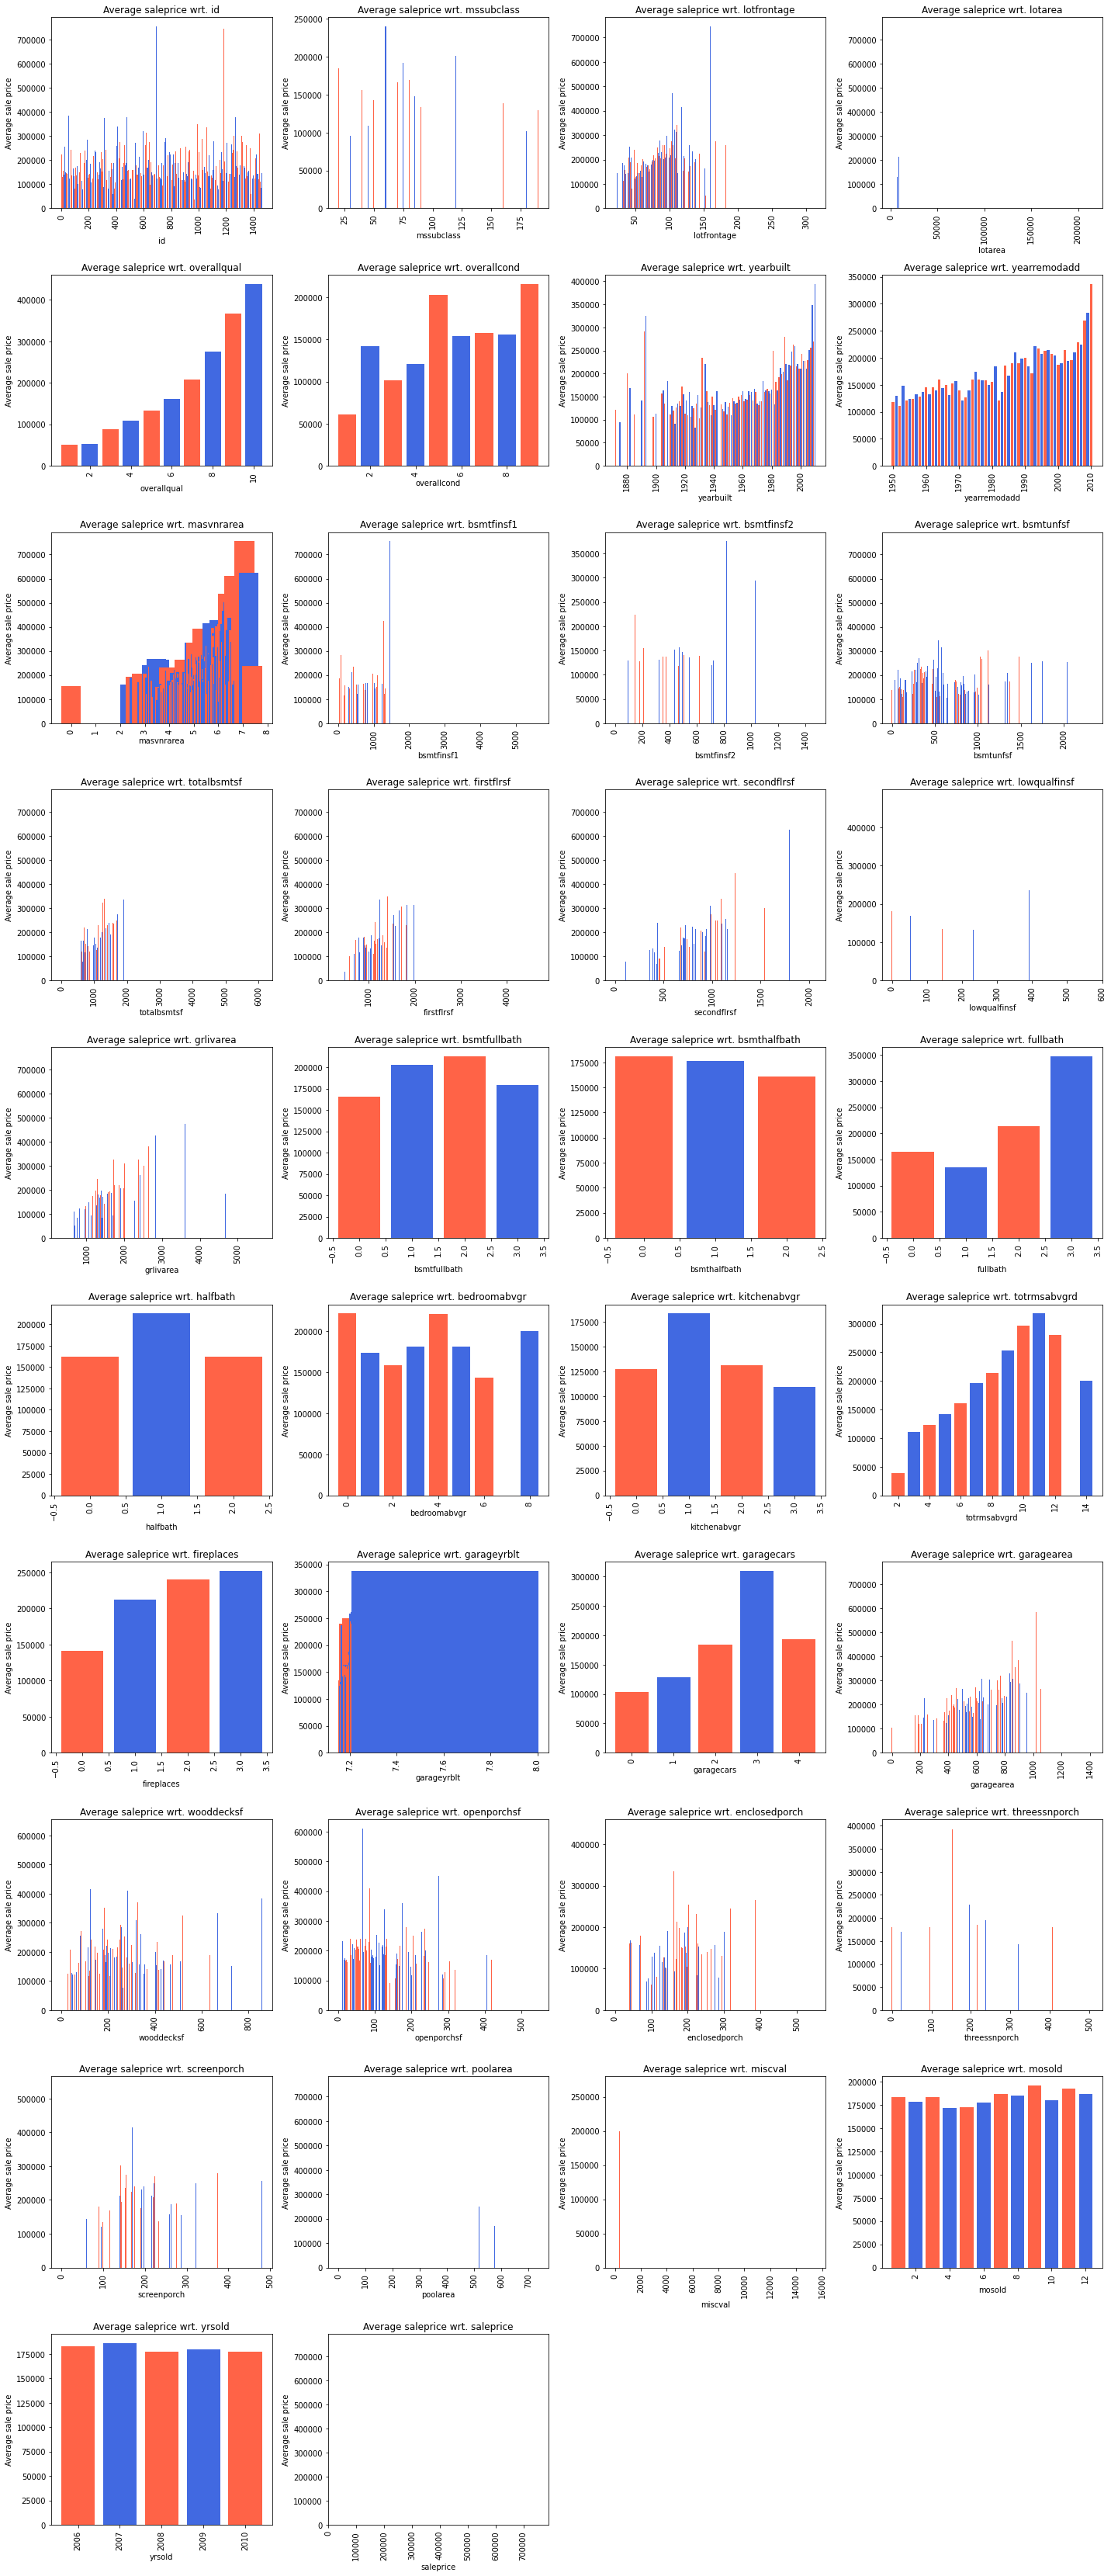

In [ ]:
plt.figure(figsize=(20,50))

for index, column in enumerate(numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, 
            house_prices_df.groupby(column)["saleprice"].mean(),
           color=("tomato","royalblue"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

### Check categorical variables

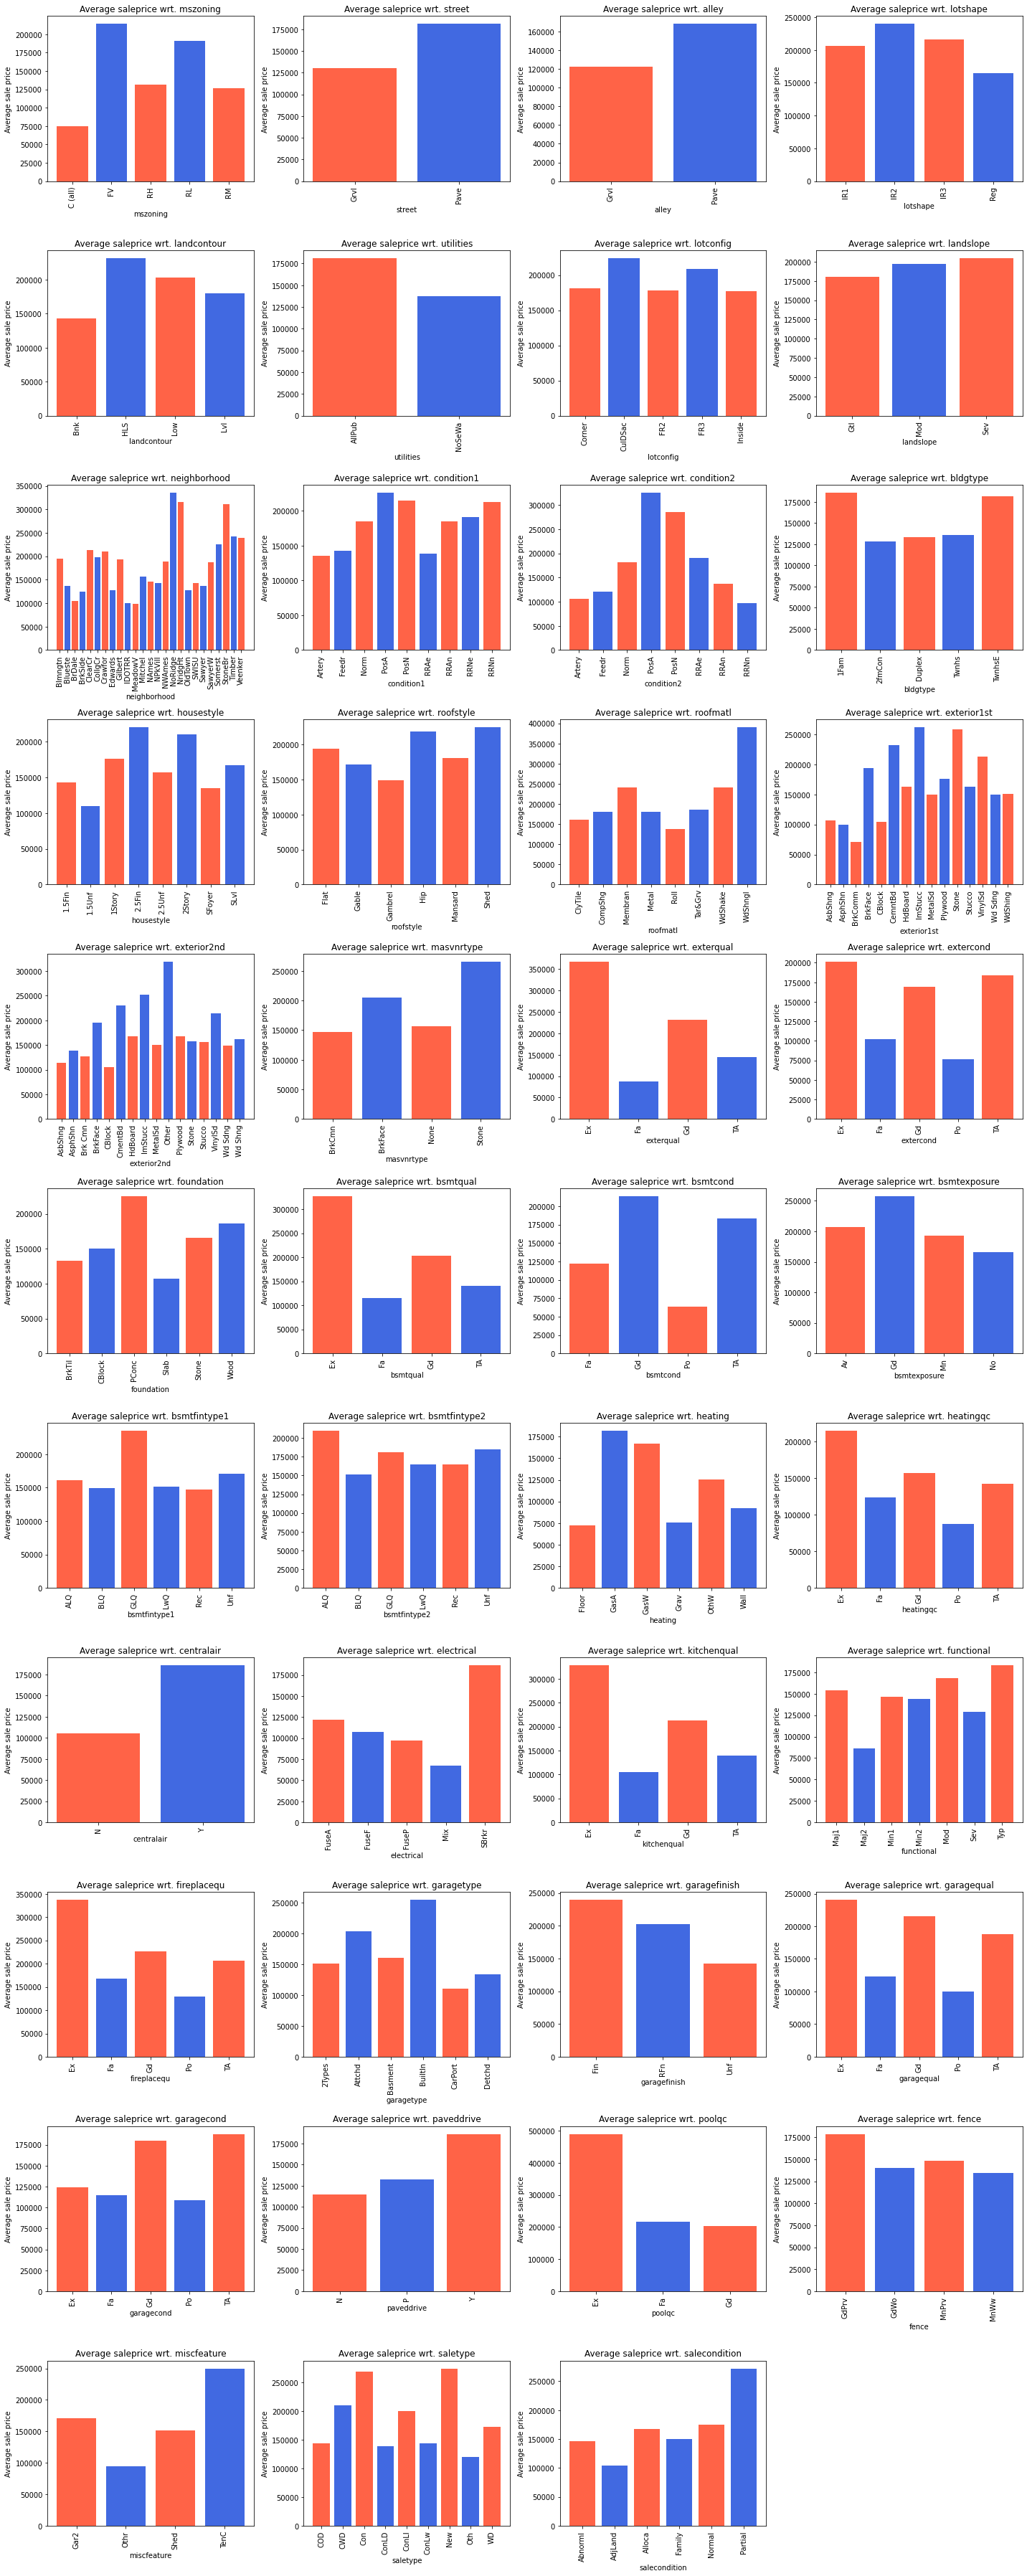

In [ ]:
plt.figure(figsize=(20,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, 
            house_prices_df.groupby(column)["saleprice"].mean(),
           color=("tomato","royalblue"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

We might anticipate dropping the features with poor distributions, class imbalances and high subjectivity.  

## Bivariate Analysis

### Check correalation between numeric predictors and target variables

In [ ]:
np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=True)

bsmtfinsf2       0.011378
bsmthalfbath     0.016844
miscval          0.021190
lowqualfinsf     0.025606
yrsold           0.028923
threessnporch    0.044584
mosold           0.046432
overallcond      0.077856
mssubclass       0.084284
poolarea         0.092404
screenporch      0.111447
enclosedporch    0.128578
kitchenabvgr     0.135907
bedroomabvgr     0.168213
bsmtunfsf        0.214479
bsmtfullbath     0.227122
masvnrarea       0.249143
lotarea          0.263843
halfbath         0.284108
openporchsf      0.315856
secondflrsf      0.319334
wooddecksf       0.324413
lotfrontage      0.351799
bsmtfinsf1       0.386420
fireplaces       0.466929
garageyrblt      0.468673
yearremodadd     0.507101
yearbuilt        0.522897
totrmsabvgrd     0.533723
fullbath         0.560664
firstflrsf       0.605852
totalbsmtsf      0.613581
garagearea       0.623431
garagecars       0.640409
grlivarea        0.708624
overallqual      0.790982
saleprice        1.000000
Name: saleprice, dtype: float64

### Visualization results with scatterplot or heatmap

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 <a list of 37 Text major ticklabel objects>)

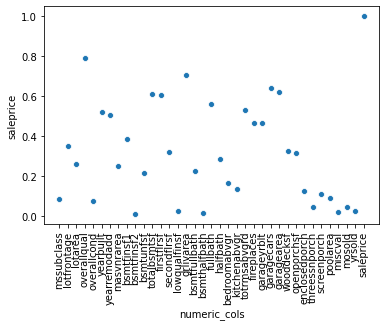

In [ ]:
corr = np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"])

corr = corr.reset_index()

corr_plot = pd.DataFrame(corr)
pd.options.display.float_format = '{:20,.2f}'.format
corr_plot.saleprice.astype(float)

# corr_plot.head()
corr_plot = corr_plot.rename(columns={'index': 'numeric_cols'})

sns.scatterplot(x='numeric_cols', y='saleprice', data=corr_plot)
plt.xticks(rotation=90)
#add y axis line for threshold prediction of best correlated features

# sns.heatmap(corr_plot) 
# ttype error could be a bug
# see https://github.com/numpy/numpy/issues/12351

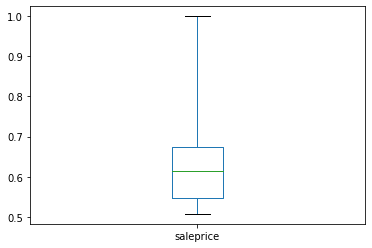

In [ ]:
#define threshold
corr_plot2 = corr_plot[corr_plot['saleprice'] > .5]

most_correlated_num_feats = corr_plot2['saleprice'].sort_values(ascending=True)

#visualize dist of low correalated feats 
most_correlated_num_feats.plot(kind='box', whis=20)


#### Above, the features with highest correlation produce a more normal distribution. We will use these for our model. 

### Check correlations between categorical features and target

In [ ]:
# hp_df.head()

#filter for dummies

# sns.pairplot(hp_df)

In [ ]:
target = house_prices_df[['saleprice']]
categoricals = house_prices_df.select_dtypes(['object'])

categoricals.isna().sum().sort_values(ascending=False)
#drop the first 14 features

# cat_target = pd.concat([target, categoricals], axis=1) #save til after dummy
# cat_target

#drop 14 features



poolqc           1453
miscfeature      1406
alley            1369
fence            1179
fireplacequ       690
garagecond         81
garagequal         81
garagefinish       81
garagetype         81
bsmtfintype2       38
bsmtexposure       38
bsmtfintype1       37
bsmtqual           37
bsmtcond           37
masvnrtype          8
electrical          1
condition2          0
condition1          0
neighborhood        0
landslope           0
bldgtype            0
landcontour         0
lotconfig           0
utilities           0
roofstyle           0
lotshape            0
street              0
housestyle          0
salecondition       0
roofmatl            0
exterior1st         0
exterior2nd         0
exterqual           0
extercond           0
foundation          0
saletype            0
heating             0
heatingqc           0
centralair          0
kitchenqual         0
functional          0
paveddrive          0
mszoning            0
dtype: int64

combine garage features? 

In [ ]:
np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

# corr = corr.reset_index()

# corr_plot = pd.DataFrame(corr)
# pd.options.display.float_format = '{:20,.2f}'.format
# corr_plot.saleprice.astype(float)

# corr_plot.head()
# corr_plot = corr_plot.rename(columns={'index': 'numeric_cols'})

# sns.scatterplot(x='numeric_cols', y='saleprice', data=corr_plot)
# plt.xticks(rotation=90)

# sns.heatmap(corr_plot) 
# ttype error could be a bug
# see https://github.com/numpy/numpy/issues/12351

saleprice                       1.00
overallqual                     0.79
grlivarea                       0.71
garagecars                      0.64
garagearea                      0.62
totalbsmtsf                     0.61
firstflrsf                      0.61
fullbath                        0.56
totrmsabvgrd                    0.53
yearbuilt                       0.52
yearremodadd                    0.51
garageyrblt                     0.47
fireplaces                      0.47
bsmtfinsf1                      0.39
lotfrontage                     0.35
wooddecksf                      0.32
secondflrsf                     0.32
openporchsf                     0.32
halfbath                        0.28
lotarea                         0.26
masvnrarea                      0.25
bsmtfullbath                    0.23
bsmtunfsf                       0.21
bedroomabvgr                    0.17
kitchenabvgr                    0.14
enclosedporch                   0.13
screenporch                     0.11
p

## Feature Engineering

### Include all promising features

### Add created dummy variables

### Create synthetic features

### Apply PCA

## Data Split

### Correctly split data into Training and Test

## Modeling 

### Apply Simple Regression

### Apply Ridge Regression

#### Tune parameters via Cross Validation


### Run Lasso Algorithm

### Run Elastic Net Algorithm

## Evaluation

### Build correct and stable accuracy measurement pipeline to evaluate output of models

#### Explain Variance

#### Explain Accuracy

### Outline Model Performance

### Adequately elaborate model performance

### Check which predictors had significant impact on target variable

### Explain how the features affected the target when less significant features are removed

## External Information

## Conclusion